In [89]:
import os
import sys
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk

%matplotlib inline

## Lightcurve

In [90]:
# Function to wrap around juliet's get_TESS_data function to deal with multiple TESS sectors
def juliet_get_tess_data(lkf):
    for indf,thisf in enumerate(lkf):
        thist,thisf,thisferr = juliet.get_TESS_data(thisf)
        if indf == 0:
            t,f,ferr = thist,thisf,thisferr
        else:
            t,f,ferr = np.concatenate((t,thist)), np.concatenate((f,thisf)), \
                np.concatenate((ferr,thisferr))
    
    return t,f,ferr

In [91]:
# Basic constants
tesst0 = 2457000.0  # BJD offset for TESS timestamps

p1 = 3.37923577236328  # period in days
perr1 = .0001425314  # error on period in days
tc1 = 2459420.207144  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0018298243  # transit midpoint in days

In [92]:
# download the lightcurve using lightkurve ;)
# Make sure to change the my_dir to the download folder you want!
my_dir = './'
lkfile = lk.search.search_lightcurvefile('TOI 4439', mission='TESS')
lkf = lkfile.download_all(download_dir=my_dir)

In [93]:
# juliet needs the fits file
lkf = glob.glob(os.path.join(my_dir, 'mastDownload/*/*/tess*.fits'))
print(lkf)

['./mastDownload/TESS/tess2022164095748-s0053-0000000267545252-0226-s/tess2022164095748-s0053-0000000267545252-0226-s_lc.fits', './mastDownload/TESS/tess2021175071901-s0040-0000000267545252-0211-s/tess2021175071901-s0040-0000000267545252-0211-s_lc.fits', './mastDownload/TESS/tess2021204101404-s0041-0000000267545252-0212-s/tess2021204101404-s0041-0000000267545252-0212-s_lc.fits']


In [94]:
t,f,ferr = juliet_get_tess_data(lkf)

(2390.6553572621588, 2768.980333642463)

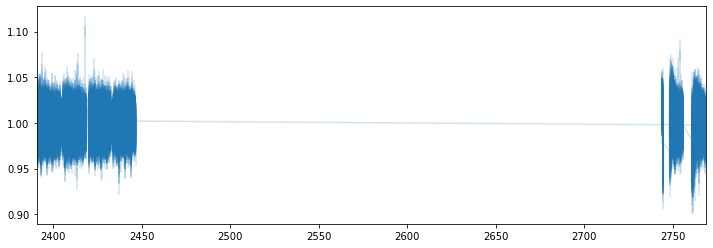

In [95]:
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Plot data:
plt.figure(figsize=(12,4))
plt.errorbar(t,f, yerr=ferr, fmt='.',alpha=0.2)
plt.xlim([np.min(t),np.max(t)])

## B Band

In [96]:
photo_file = f'./photometry_data/TOI-4439-B.csv'
df = pd.read_csv(photo_file)
print(df.head())
t = np.array(df['time'])
flux = np.array(df['flux'])
flux_err = np.array(df['flux_err'])

# normalize flux
flux_mean = flux.mean()
flux, flux_err = flux/flux_mean, flux_err/flux_mean

times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, flux, flux_err

           time      flux  flux_err
0  2.459714e+06  0.257930  0.004213
1  2.459714e+06  0.250827  0.003911
2  2.459714e+06  0.245281  0.003733
3  2.459714e+06  0.245579  0.003621
4  2.459714e+06  0.246836  0.003477


In [97]:
dataset = juliet.load(priors=f'./transit_fit_4439_B/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = f'./transit_fit_4439_B')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_B/_dynesty_NS_posteriors.pkl


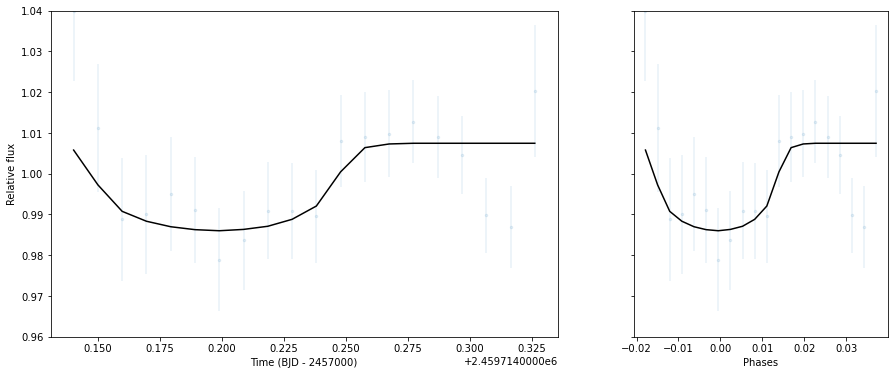

In [98]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')
plt.show()

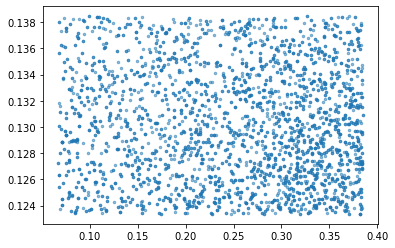

In [99]:
infile = open('./transit_fit_4439_B/_dynesty_NS_posteriors.pkl','rb')
posteriors = pickle.load(infile)
infile.close()

# extract r1 and r2
r1, r2 = posteriors['posterior_samples']['r1_p1'],\
         posteriors['posterior_samples']['r2_p1']
         
# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)

## R Band

In [100]:
photo_file = f'./photometry_data/TOI-4439-R.csv'
df = pd.read_csv(photo_file)
print(df.head())
t = np.array(df['time'])
flux = np.array(df['flux'])
flux_err = np.array(df['flux_err'])

# normalize flux
flux_mean = flux.mean()
flux, flux_err = flux/flux_mean, flux_err/flux_mean

times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, flux, flux_err

           time      flux  flux_err
0  2.459714e+06  0.286553  0.001315
1  2.459714e+06  0.283441  0.001267
2  2.459714e+06  0.282399  0.001258
3  2.459714e+06  0.282770  0.001205
4  2.459714e+06  0.284356  0.001146


In [101]:
dataset = juliet.load(priors=f'./transit_fit_4439_R/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = f'./transit_fit_4439_R')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_R/_dynesty_NS_posteriors.pkl


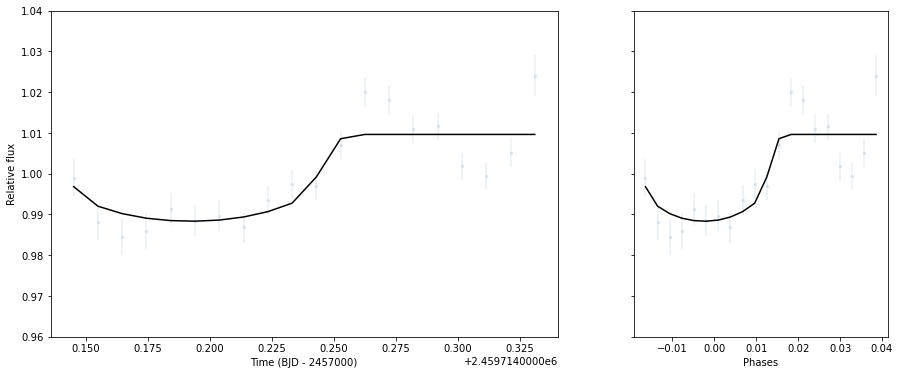

In [102]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')
plt.show()

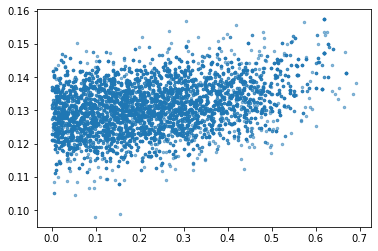

In [103]:
infile = open('./transit_fit_4439_R/_dynesty_NS_posteriors.pkl','rb')
posteriors = pickle.load(infile)
infile.close()

# extract r1 and r2
r1, r2 = posteriors['posterior_samples']['r1_p1'],\
         posteriors['posterior_samples']['r2_p1']
         
# Transform back to (b,p):
b,p = juliet.utils.reverse_bp(r1, r2, 0., 1.)

# Plot posterior distribution:
plt.plot(b,p,'.',alpha=0.5)